In [1]:
!pwd
%cd drive/MyDrive/nlp100/chapter08

/content
/content/drive/MyDrive/nlp100/chapter08


In [3]:
# knock50

import pandas as pd
from sklearn.model_selection import train_test_split
# FORMAT: ID \t TITLE \t URL \t PUBLISHER \t CATEGORY \t STORY \t HOSTNAME \t TIMESTAMP
df = pd.read_csv("newsCorpora.csv", sep="\t", header=None, names=["ID", "TITLE", "URL", "PUBLISHER", "CATEGORY", "STORY", "HOSTNAME", "TIMESTAMP"])

# 該当するpublisherの記事を抽出する
publishers = ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']
df = df[df['PUBLISHER'].isin(publishers)]
# TITLEとCATEGORYのみ抽出
df = df[["TITLE", "CATEGORY"]]

#データを分割しシャッフルする
train, test = train_test_split(df, test_size=0.2, shuffle=True)
test, valid = train_test_split(test, test_size=0.5, shuffle=True)

#ファイルに保存する
train.to_csv("train.txt", sep="\t", index=False, header=None)
valid.to_csv("valid.txt", sep="\t", index=False, header=None)
test.to_csv("test.txt", sep="\t", index=False, header=None)

print("train\n", train["CATEGORY"].value_counts())
print("valid\n", valid["CATEGORY"].value_counts())
print("test\n", test["CATEGORY"].value_counts())

train
 b    4512
e    4193
t    1245
m     722
Name: CATEGORY, dtype: int64
valid
 b    552
e    550
t    140
m     92
Name: CATEGORY, dtype: int64
test
 b    563
e    536
t    139
m     96
Name: CATEGORY, dtype: int64


In [5]:
# knock60

from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format("GoogleNews-vectors-negative300.bin.gz", binary=True)

In [6]:
# knock70
import string
import torch
from tqdm import tqdm

# タイトルを特徴ベクトル化する
def transform_w2v(text):
  # 記号を削除する
  table = str.maketrans(string.punctuation, ' '*len(string.punctuation)) # 記号をスペースに置換する文字列変換を作成
  words = text.translate(table).split() # 変換を実行してスペースで分割する
  vec = []
  # ベクトル化する
  for word in words:
    if word in model:
      vec.append(model[word])
  return torch.tensor(sum(vec) / len(vec))

# 特徴ベクトルを作成
X_train = torch.stack([transform_w2v(text) for text in train['TITLE']])
X_valid = torch.stack([transform_w2v(text) for text in valid['TITLE']])
X_test = torch.stack([transform_w2v(text) for text in test['TITLE']])

print(X_train)

# ラベルベクトルを作成
category = {'b': 0, 't': 1, 'e': 2, 'm': 3}
# カテゴリ名を数字に変えてテンソル化
y_train = torch.tensor(train['CATEGORY'].map(lambda x: category[x]).values)
y_valid = torch.tensor(valid['CATEGORY'].map(lambda x: category[x]).values)
y_test = torch.tensor(test['CATEGORY'].map(lambda x: category[x]).values)

print(y_train)

torch.save(X_train, 'X_train.pt')
torch.save(X_valid, 'X_valid.pt')
torch.save(X_test, 'X_test.pt')
torch.save(y_train, 'y_train.pt')
torch.save(y_valid, 'y_valid.pt')
torch.save(y_test, 'y_test.pt')

tensor([[ 0.0492,  0.0744, -0.0350,  ..., -0.0232, -0.0503,  0.0168],
        [-0.1302, -0.0141, -0.1621,  ..., -0.2249,  0.0951, -0.0289],
        [-0.0189,  0.1470, -0.0144,  ..., -0.0099, -0.1147, -0.0141],
        ...,
        [ 0.0119, -0.0768,  0.0264,  ...,  0.0289,  0.0988, -0.0251],
        [ 0.1484,  0.0615,  0.0196,  ..., -0.1033,  0.0074, -0.0169],
        [-0.0288, -0.0532,  0.0273,  ...,  0.0379,  0.0096, -0.0588]])
tensor([0, 1, 2,  ..., 0, 2, 0])


In [8]:
# knock71
from torch import nn

class SLPNet(nn.Module):
  def __init__(self, input_size, output_size):
    # 以下の処理を追加
    super().__init__()
    # 全結合層を定義
    self.fc = nn.Linear(input_size, output_size, bias=False)
    # 正規乱数で重みを初期化する
    nn.init.normal_(self.fc.weight, 0.0, 1.0)

  def forward(self, x):
    x = self.fc(x)
    return x

# 単層ニューラルネットワークを初期化
model = SLPNet(300, 4)
y_hat_1 = torch.softmax(model(X_train[:1]), dim=-1)
print(y_hat_1)
Y_hat = torch.softmax(model.forward(X_train[:4]), dim=-1)
print(Y_hat)

tensor([[0.1505, 0.1515, 0.1026, 0.5954]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1505, 0.1515, 0.1026, 0.5954],
        [0.9185, 0.0344, 0.0156, 0.0314],
        [0.0233, 0.8224, 0.0316, 0.1228],
        [0.6739, 0.2179, 0.0583, 0.0499]], grad_fn=<SoftmaxBackward0>)


In [13]:
# knock72

criterion = nn.CrossEntropyLoss()
l_1 = criterion(model(X_train[:1]), y_train[:1])
model.zero_grad()
l_1.backward()
print(f'損失: {l_1}')
print(f'勾配:\n{model.fc.weight.grad}')

l = criterion(model(X_train[:4]), y_train[:4])
model.zero_grad()
l.backward()
print(f'損失: {l}')
print(f'勾配:\n{model.fc.weight.grad}')

損失: 2.0781850814819336
勾配:
tensor([[ 0.0041,  0.0149, -0.0045,  ...,  0.0466, -0.0164,  0.0348],
        [ 0.0026,  0.0093, -0.0028,  ...,  0.0290, -0.0102,  0.0216],
        [ 0.0007,  0.0027, -0.0008,  ...,  0.0083, -0.0029,  0.0062],
        [-0.0074, -0.0268,  0.0080,  ..., -0.0839,  0.0294, -0.0625]])
損失: 1.9201526641845703
勾配:
tensor([[ 0.0096, -0.0063, -0.0268,  ..., -0.0004, -0.0081,  0.0175],
        [-0.0104, -0.0024,  0.0064,  ...,  0.0211, -0.0122,  0.0284],
        [ 0.0055,  0.0049,  0.0090,  ...,  0.0115, -0.0041,  0.0040],
        [-0.0047,  0.0038,  0.0114,  ..., -0.0321,  0.0245, -0.0498]])


In [14]:
# knock73

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderを作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

model = SLPNet(300, 4)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 学習
num_epochs = 100
for epoch in tqdm(range(num_epochs)):
  model.train()
  loss_train = 0.0
  for i, (inputs, labels) in enumerate(dataloader_train):
    optimizer.zero_grad()
    # 順伝播
    outputs = model(inputs)
    # 誤差逆伝播
    loss = criterion(outputs, labels)
    loss.backward()
    # 更新
    optimizer.step()

    loss_train += loss.item()
  # 平均損失を計算
  loss_train = loss_train / i
  # 検証データの損失を計算
  model.eval()
  with torch.no_grad():
    inputs, labels = next(iter(dataloader_valid))
    outputs = model(inputs)
    loss_valid = criterion(outputs, labels)
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}')

  1%|          | 1/100 [00:05<09:04,  5.50s/it]

epoch: 1, loss_train: 0.4619, loss_valid: 0.3504


  2%|▏         | 2/100 [00:09<07:54,  4.84s/it]

epoch: 2, loss_train: 0.3134, loss_valid: 0.3174


  3%|▎         | 3/100 [00:13<07:11,  4.45s/it]

epoch: 3, loss_train: 0.2842, loss_valid: 0.2989


  4%|▍         | 4/100 [00:18<07:07,  4.45s/it]

epoch: 4, loss_train: 0.2694, loss_valid: 0.2915


  5%|▌         | 5/100 [00:22<07:09,  4.52s/it]

epoch: 5, loss_train: 0.2585, loss_valid: 0.2833


  6%|▌         | 6/100 [00:26<06:45,  4.32s/it]

epoch: 6, loss_train: 0.2509, loss_valid: 0.2809


  7%|▋         | 7/100 [00:30<06:29,  4.19s/it]

epoch: 7, loss_train: 0.2450, loss_valid: 0.2752


  8%|▊         | 8/100 [00:35<06:48,  4.44s/it]

epoch: 8, loss_train: 0.2404, loss_valid: 0.2736


  9%|▉         | 9/100 [00:39<06:30,  4.29s/it]

epoch: 9, loss_train: 0.2374, loss_valid: 0.2718


 10%|█         | 10/100 [00:43<06:16,  4.18s/it]

epoch: 10, loss_train: 0.2338, loss_valid: 0.2715


 11%|█         | 11/100 [00:48<06:29,  4.38s/it]

epoch: 11, loss_train: 0.2317, loss_valid: 0.2723


 12%|█▏        | 12/100 [00:52<06:14,  4.26s/it]

epoch: 12, loss_train: 0.2298, loss_valid: 0.2702


 13%|█▎        | 13/100 [00:56<06:02,  4.17s/it]

epoch: 13, loss_train: 0.2284, loss_valid: 0.2693


 14%|█▍        | 14/100 [01:01<06:21,  4.43s/it]

epoch: 14, loss_train: 0.2262, loss_valid: 0.2688


 15%|█▌        | 15/100 [01:05<06:12,  4.38s/it]

epoch: 15, loss_train: 0.2254, loss_valid: 0.2694


 16%|█▌        | 16/100 [01:09<05:55,  4.23s/it]

epoch: 16, loss_train: 0.2236, loss_valid: 0.2672


 17%|█▋        | 17/100 [01:13<05:52,  4.24s/it]

epoch: 17, loss_train: 0.2229, loss_valid: 0.2679


 18%|█▊        | 18/100 [01:18<06:01,  4.41s/it]

epoch: 18, loss_train: 0.2222, loss_valid: 0.2694


 19%|█▉        | 19/100 [01:22<05:45,  4.26s/it]

epoch: 19, loss_train: 0.2207, loss_valid: 0.2694


 20%|██        | 20/100 [01:26<05:33,  4.17s/it]

epoch: 20, loss_train: 0.2202, loss_valid: 0.2722


 21%|██        | 21/100 [01:31<05:47,  4.40s/it]

epoch: 21, loss_train: 0.2198, loss_valid: 0.2711


 22%|██▏       | 22/100 [01:35<05:34,  4.29s/it]

epoch: 22, loss_train: 0.2188, loss_valid: 0.2726


 23%|██▎       | 23/100 [01:39<05:20,  4.17s/it]

epoch: 23, loss_train: 0.2183, loss_valid: 0.2792


 24%|██▍       | 24/100 [01:44<05:31,  4.37s/it]

epoch: 24, loss_train: 0.2174, loss_valid: 0.2744


 25%|██▌       | 25/100 [01:50<06:01,  4.81s/it]

epoch: 25, loss_train: 0.2173, loss_valid: 0.2728


 26%|██▌       | 26/100 [01:54<05:36,  4.54s/it]

epoch: 26, loss_train: 0.2166, loss_valid: 0.2791


 27%|██▋       | 27/100 [01:59<05:41,  4.67s/it]

epoch: 27, loss_train: 0.2163, loss_valid: 0.2759


 28%|██▊       | 28/100 [02:02<05:18,  4.43s/it]

epoch: 28, loss_train: 0.2158, loss_valid: 0.2748


 29%|██▉       | 29/100 [02:06<05:02,  4.26s/it]

epoch: 29, loss_train: 0.2155, loss_valid: 0.2734


 30%|███       | 30/100 [02:11<05:09,  4.42s/it]

epoch: 30, loss_train: 0.2148, loss_valid: 0.2749


 31%|███       | 31/100 [02:15<04:59,  4.34s/it]

epoch: 31, loss_train: 0.2141, loss_valid: 0.2858


 32%|███▏      | 32/100 [02:19<04:54,  4.33s/it]

epoch: 32, loss_train: 0.2139, loss_valid: 0.2839


 33%|███▎      | 33/100 [02:26<05:26,  4.88s/it]

epoch: 33, loss_train: 0.2144, loss_valid: 0.2763


 34%|███▍      | 34/100 [02:30<05:07,  4.66s/it]

epoch: 34, loss_train: 0.2138, loss_valid: 0.2791


 35%|███▌      | 35/100 [02:34<04:50,  4.47s/it]

epoch: 35, loss_train: 0.2138, loss_valid: 0.2762


 36%|███▌      | 36/100 [02:39<04:58,  4.66s/it]

epoch: 36, loss_train: 0.2133, loss_valid: 0.2782


 37%|███▋      | 37/100 [02:43<04:50,  4.60s/it]

epoch: 37, loss_train: 0.2123, loss_valid: 0.2829


 38%|███▊      | 38/100 [02:48<04:42,  4.56s/it]

epoch: 38, loss_train: 0.2129, loss_valid: 0.2814


 39%|███▉      | 39/100 [02:52<04:35,  4.52s/it]

epoch: 39, loss_train: 0.2126, loss_valid: 0.2816


 40%|████      | 40/100 [02:57<04:33,  4.55s/it]

epoch: 40, loss_train: 0.2123, loss_valid: 0.2803


 41%|████      | 41/100 [03:01<04:18,  4.39s/it]

epoch: 41, loss_train: 0.2115, loss_valid: 0.2845


 42%|████▏     | 42/100 [03:05<04:09,  4.29s/it]

epoch: 42, loss_train: 0.2124, loss_valid: 0.2798


 43%|████▎     | 43/100 [03:10<04:13,  4.44s/it]

epoch: 43, loss_train: 0.2120, loss_valid: 0.2811


 44%|████▍     | 44/100 [03:14<03:59,  4.28s/it]

epoch: 44, loss_train: 0.2114, loss_valid: 0.2863


 45%|████▌     | 45/100 [03:18<03:50,  4.19s/it]

epoch: 45, loss_train: 0.2117, loss_valid: 0.2838


 46%|████▌     | 46/100 [03:23<04:00,  4.45s/it]

epoch: 46, loss_train: 0.2112, loss_valid: 0.2822


 47%|████▋     | 47/100 [03:27<03:46,  4.28s/it]

epoch: 47, loss_train: 0.2110, loss_valid: 0.2818


 48%|████▊     | 48/100 [03:30<03:36,  4.16s/it]

epoch: 48, loss_train: 0.2100, loss_valid: 0.2874


 49%|████▉     | 49/100 [03:35<03:40,  4.32s/it]

epoch: 49, loss_train: 0.2106, loss_valid: 0.2850


 50%|█████     | 50/100 [03:39<03:34,  4.29s/it]

epoch: 50, loss_train: 0.2110, loss_valid: 0.2869


 51%|█████     | 51/100 [03:43<03:24,  4.17s/it]

epoch: 51, loss_train: 0.2108, loss_valid: 0.2857


 52%|█████▏    | 52/100 [03:48<03:23,  4.24s/it]

epoch: 52, loss_train: 0.2109, loss_valid: 0.2844


 53%|█████▎    | 53/100 [03:53<03:28,  4.43s/it]

epoch: 53, loss_train: 0.2098, loss_valid: 0.2850


 54%|█████▍    | 54/100 [03:56<03:17,  4.28s/it]

epoch: 54, loss_train: 0.2104, loss_valid: 0.2885


 55%|█████▌    | 55/100 [04:01<03:10,  4.23s/it]

epoch: 55, loss_train: 0.2104, loss_valid: 0.2846


 56%|█████▌    | 56/100 [04:05<03:13,  4.41s/it]

epoch: 56, loss_train: 0.2100, loss_valid: 0.2874


 57%|█████▋    | 57/100 [04:09<03:03,  4.26s/it]

epoch: 57, loss_train: 0.2095, loss_valid: 0.2880


 58%|█████▊    | 58/100 [04:13<02:54,  4.17s/it]

epoch: 58, loss_train: 0.2096, loss_valid: 0.2879


 59%|█████▉    | 59/100 [04:19<03:04,  4.49s/it]

epoch: 59, loss_train: 0.2097, loss_valid: 0.2894


 60%|██████    | 60/100 [04:23<02:53,  4.35s/it]

epoch: 60, loss_train: 0.2099, loss_valid: 0.2891


 61%|██████    | 61/100 [04:26<02:44,  4.22s/it]

epoch: 61, loss_train: 0.2093, loss_valid: 0.2874


 62%|██████▏   | 62/100 [04:31<02:49,  4.46s/it]

epoch: 62, loss_train: 0.2092, loss_valid: 0.2880


 63%|██████▎   | 63/100 [04:36<02:41,  4.37s/it]

epoch: 63, loss_train: 0.2097, loss_valid: 0.2904


 64%|██████▍   | 64/100 [04:40<02:32,  4.24s/it]

epoch: 64, loss_train: 0.2089, loss_valid: 0.2966


 65%|██████▌   | 65/100 [04:44<02:32,  4.34s/it]

epoch: 65, loss_train: 0.2095, loss_valid: 0.2908


 66%|██████▌   | 66/100 [04:49<02:29,  4.39s/it]

epoch: 66, loss_train: 0.2093, loss_valid: 0.2909


 67%|██████▋   | 67/100 [04:53<02:19,  4.23s/it]

epoch: 67, loss_train: 0.2091, loss_valid: 0.2906


 68%|██████▊   | 68/100 [04:57<02:16,  4.27s/it]

epoch: 68, loss_train: 0.2093, loss_valid: 0.2933


 69%|██████▉   | 69/100 [05:02<02:17,  4.42s/it]

epoch: 69, loss_train: 0.2083, loss_valid: 0.2911


 70%|███████   | 70/100 [05:06<02:08,  4.30s/it]

epoch: 70, loss_train: 0.2095, loss_valid: 0.2915


 71%|███████   | 71/100 [05:10<02:02,  4.21s/it]

epoch: 71, loss_train: 0.2094, loss_valid: 0.2891


 72%|███████▏  | 72/100 [05:15<02:04,  4.45s/it]

epoch: 72, loss_train: 0.2086, loss_valid: 0.2928


 73%|███████▎  | 73/100 [05:20<02:03,  4.59s/it]

epoch: 73, loss_train: 0.2087, loss_valid: 0.2929


 74%|███████▍  | 74/100 [05:24<02:01,  4.69s/it]

epoch: 74, loss_train: 0.2084, loss_valid: 0.2899


 75%|███████▌  | 75/100 [05:29<01:57,  4.71s/it]

epoch: 75, loss_train: 0.2079, loss_valid: 0.2930


 76%|███████▌  | 76/100 [05:33<01:47,  4.49s/it]

epoch: 76, loss_train: 0.2090, loss_valid: 0.2933


 77%|███████▋  | 77/100 [05:39<01:50,  4.79s/it]

epoch: 77, loss_train: 0.2085, loss_valid: 0.2944


 78%|███████▊  | 78/100 [05:55<02:59,  8.16s/it]

epoch: 78, loss_train: 0.2084, loss_valid: 0.2951


 79%|███████▉  | 79/100 [06:00<02:31,  7.23s/it]

epoch: 79, loss_train: 0.2084, loss_valid: 0.2943


 80%|████████  | 80/100 [06:05<02:11,  6.56s/it]

epoch: 80, loss_train: 0.2084, loss_valid: 0.3015


 81%|████████  | 81/100 [06:09<01:53,  5.97s/it]

epoch: 81, loss_train: 0.2083, loss_valid: 0.2917


 82%|████████▏ | 82/100 [06:14<01:39,  5.50s/it]

epoch: 82, loss_train: 0.2088, loss_valid: 0.2955


 83%|████████▎ | 83/100 [06:19<01:33,  5.50s/it]

epoch: 83, loss_train: 0.2080, loss_valid: 0.2948


 84%|████████▍ | 84/100 [06:24<01:25,  5.35s/it]

epoch: 84, loss_train: 0.2082, loss_valid: 0.2962


 85%|████████▌ | 85/100 [06:29<01:17,  5.15s/it]

epoch: 85, loss_train: 0.2079, loss_valid: 0.2948


 86%|████████▌ | 86/100 [06:33<01:09,  4.96s/it]

epoch: 86, loss_train: 0.2081, loss_valid: 0.2953


 87%|████████▋ | 87/100 [06:37<01:00,  4.67s/it]

epoch: 87, loss_train: 0.2081, loss_valid: 0.2968


 88%|████████▊ | 88/100 [06:45<01:07,  5.60s/it]

epoch: 88, loss_train: 0.2081, loss_valid: 0.2987


 89%|████████▉ | 89/100 [06:51<01:02,  5.65s/it]

epoch: 89, loss_train: 0.2084, loss_valid: 0.2948


 90%|█████████ | 90/100 [06:59<01:04,  6.47s/it]

epoch: 90, loss_train: 0.2081, loss_valid: 0.2998


 91%|█████████ | 91/100 [07:06<00:59,  6.62s/it]

epoch: 91, loss_train: 0.2080, loss_valid: 0.2973


 92%|█████████▏| 92/100 [07:17<01:01,  7.69s/it]

epoch: 92, loss_train: 0.2079, loss_valid: 0.2954


 93%|█████████▎| 93/100 [07:21<00:47,  6.73s/it]

epoch: 93, loss_train: 0.2078, loss_valid: 0.2953


 94%|█████████▍| 94/100 [07:29<00:41,  6.99s/it]

epoch: 94, loss_train: 0.2080, loss_valid: 0.2962


 95%|█████████▌| 95/100 [07:33<00:30,  6.10s/it]

epoch: 95, loss_train: 0.2073, loss_valid: 0.2977


 96%|█████████▌| 96/100 [07:38<00:22,  5.75s/it]

epoch: 96, loss_train: 0.2083, loss_valid: 0.2977


 97%|█████████▋| 97/100 [07:44<00:18,  6.02s/it]

epoch: 97, loss_train: 0.2078, loss_valid: 0.2970


 98%|█████████▊| 98/100 [07:51<00:12,  6.20s/it]

epoch: 98, loss_train: 0.2082, loss_valid: 0.2987


 99%|█████████▉| 99/100 [07:58<00:06,  6.57s/it]

epoch: 99, loss_train: 0.2074, loss_valid: 0.2988


100%|██████████| 100/100 [08:03<00:00,  4.84s/it]

epoch: 100, loss_train: 0.2071, loss_valid: 0.2987


In [15]:
# knock74

def calculate_accuracy(model, loader):
  model.eval()
  total = 0
  correct = 0
  with torch.no_grad():
    for inputs, labels in loader:
      outputs = model(inputs)
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return correct / total

acc_train = calculate_accuracy(model, dataloader_train)
acc_test = calculate_accuracy(model, dataloader_test)
print(f'学習データ: {acc_train}')
print(f'評価データ: {acc_test}')

学習データ: 0.930003748125937
評価データ: 0.8905547226386806


In [20]:
# knock75
from matplotlib import pyplot as plt

def calculate_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配を変更しない（リークを防ぐ）
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderを作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

# モデルを定義
model = SLPNet(300, 4)
# 損失関数を定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in tqdm(range(num_epochs)):
  model.train() # 訓練モード
  loss_train = 0.0
  for inputs, labels in dataloader_train:
    optimizer.zero_grad() # 勾配をゼロに初期化
    # 順伝播
    outputs = model(inputs)
    # 誤差逆伝播
    loss = criterion(outputs, labels)
    loss.backward()
    # 重み更新
    optimizer.step()

  # 検証データの損失を計算・正解率も計算
  loss_train, acc_train = calculate_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])
  print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid}')

  5%|▌         | 1/20 [00:06<02:12,  6.96s/it]

epoch: 1, loss_train: 0.3214, loss_valid: 0.3332, accuracy_valid: 0.883808095952024


 10%|█         | 2/20 [00:12<01:53,  6.32s/it]

epoch: 2, loss_train: 0.2810, loss_valid: 0.3015, accuracy_valid: 0.8898050974512743


 15%|█▌        | 3/20 [00:20<02:00,  7.08s/it]

epoch: 3, loss_train: 0.2663, loss_valid: 0.2930, accuracy_valid: 0.8883058470764618


 20%|██        | 4/20 [00:26<01:46,  6.64s/it]

epoch: 4, loss_train: 0.2545, loss_valid: 0.2837, accuracy_valid: 0.896551724137931


 25%|██▌       | 5/20 [00:34<01:46,  7.07s/it]

epoch: 5, loss_train: 0.2450, loss_valid: 0.2788, accuracy_valid: 0.8980509745127436


 30%|███       | 6/20 [00:40<01:33,  6.65s/it]

epoch: 6, loss_train: 0.2378, loss_valid: 0.2715, accuracy_valid: 0.9025487256371814


 35%|███▌      | 7/20 [00:47<01:27,  6.73s/it]

epoch: 7, loss_train: 0.2339, loss_valid: 0.2719, accuracy_valid: 0.9025487256371814


 40%|████      | 8/20 [00:55<01:27,  7.29s/it]

epoch: 8, loss_train: 0.2294, loss_valid: 0.2704, accuracy_valid: 0.8973013493253373


 45%|████▌     | 9/20 [01:09<01:40,  9.13s/it]

epoch: 9, loss_train: 0.2290, loss_valid: 0.2729, accuracy_valid: 0.8973013493253373


 50%|█████     | 10/20 [01:22<01:45, 10.57s/it]

epoch: 10, loss_train: 0.2272, loss_valid: 0.2703, accuracy_valid: 0.9002998500749625


 55%|█████▌    | 11/20 [01:34<01:37, 10.83s/it]

epoch: 11, loss_train: 0.2264, loss_valid: 0.2702, accuracy_valid: 0.8973013493253373


 60%|██████    | 12/20 [01:42<01:21, 10.15s/it]

epoch: 12, loss_train: 0.2209, loss_valid: 0.2683, accuracy_valid: 0.9010494752623688


 65%|██████▌   | 13/20 [01:51<01:08,  9.77s/it]

epoch: 13, loss_train: 0.2214, loss_valid: 0.2707, accuracy_valid: 0.8980509745127436


 70%|███████   | 14/20 [01:58<00:52,  8.74s/it]

epoch: 14, loss_train: 0.2198, loss_valid: 0.2698, accuracy_valid: 0.896551724137931


 75%|███████▌  | 15/20 [02:05<00:41,  8.35s/it]

epoch: 15, loss_train: 0.2177, loss_valid: 0.2693, accuracy_valid: 0.9017991004497751


 80%|████████  | 16/20 [02:12<00:31,  7.85s/it]

epoch: 16, loss_train: 0.2184, loss_valid: 0.2719, accuracy_valid: 0.896551724137931


 85%|████████▌ | 17/20 [02:18<00:22,  7.51s/it]

epoch: 17, loss_train: 0.2149, loss_valid: 0.2688, accuracy_valid: 0.9025487256371814


 90%|█████████ | 18/20 [02:25<00:14,  7.15s/it]

epoch: 18, loss_train: 0.2152, loss_valid: 0.2698, accuracy_valid: 0.904047976011994


 95%|█████████▌| 19/20 [02:36<00:08,  8.26s/it]

epoch: 19, loss_train: 0.2152, loss_valid: 0.2743, accuracy_valid: 0.8995502248875562


100%|██████████| 20/20 [02:45<00:00,  8.28s/it]

epoch: 20, loss_train: 0.2149, loss_valid: 0.2734, accuracy_valid: 0.8973013493253373


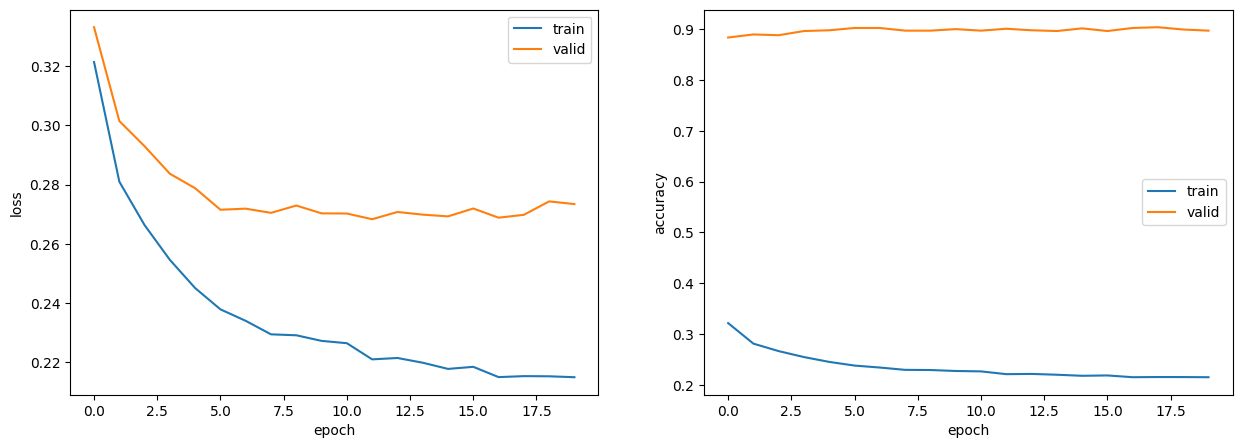

In [21]:
import numpy as np
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(np.array(log_train).T[0], label='train')
ax[0].plot(np.array(log_valid).T[0], label='valid')
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].legend()
ax[1].plot(np.array(log_train).T[0], label='train')
ax[1].plot(np.array(log_valid).T[1], label='valid')
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('accuracy')
ax[1].legend()
plt.show()

In [22]:
# knock76

def calculate_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配を変更しない（リークを防ぐ）
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)
dataset_test = NewsDataset(X_test, y_test)

# Dataloaderを作成
dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
dataloader_test = DataLoader(dataset_test, batch_size=len(dataset_test), shuffle=False)

# モデルを定義
model = SLPNet(300, 4)
# 損失関数を定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 学習
num_epochs = 20
log_train = []
log_valid = []
for epoch in tqdm(range(num_epochs)):
  model.train() # 訓練モード
  loss_train = 0.0
  for inputs, labels in dataloader_train:
    optimizer.zero_grad() # 勾配をゼロに初期化
    # 順伝播
    outputs = model(inputs)
    # 誤差逆伝播
    loss = criterion(outputs, labels)
    loss.backward()
    # 重み更新
    optimizer.step()

  # 検証データの損失を計算・正解率も計算
  loss_train, acc_train = calculate_accuracy(model, criterion, dataloader_train)
  loss_valid, acc_valid = calculate_accuracy(model, criterion, dataloader_valid)
  log_train.append([loss_train, acc_train])
  log_valid.append([loss_valid, acc_valid])

  # チェックポイントを保存
  torch.save({'epoch' : epoch, 'modelstate_dict' : model.state_dict(), 'optimizerstate_dict' : optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')
  print(f'epoch: {epoch + 1}, loss_train: {loss_train}, accuracy_train: {acc_train}, loss_valid: {loss_valid}, accuracy_valid: {acc_valid}')

  5%|▌         | 1/20 [00:06<01:59,  6.30s/it]

epoch: 1, loss_train: 0.3290910126970287, accuracy_train: 0.8861506746626686, loss_valid: 0.34351298213005066, accuracy_valid: 0.876311844077961


 10%|█         | 2/20 [00:13<02:04,  6.92s/it]

epoch: 2, loss_train: 0.2862769230858871, accuracy_train: 0.9028298350824587, loss_valid: 0.3074807822704315, accuracy_valid: 0.8913043478260869


 15%|█▌        | 3/20 [00:22<02:08,  7.58s/it]

epoch: 3, loss_train: 0.26809917291718804, accuracy_train: 0.9100449775112444, loss_valid: 0.29462534189224243, accuracy_valid: 0.8943028485757122


 20%|██        | 4/20 [00:27<01:51,  6.94s/it]

epoch: 4, loss_train: 0.26452255908158695, accuracy_train: 0.9067653673163418, loss_valid: 0.2967808246612549, accuracy_valid: 0.8980509745127436


 25%|██▌       | 5/20 [00:34<01:40,  6.68s/it]

epoch: 5, loss_train: 0.2458724909861983, accuracy_train: 0.9166979010494752, loss_valid: 0.2813476026058197, accuracy_valid: 0.8943028485757122


 30%|███       | 6/20 [00:42<01:41,  7.25s/it]

epoch: 6, loss_train: 0.24162052863159303, accuracy_train: 0.9191341829085458, loss_valid: 0.27820420265197754, accuracy_valid: 0.8995502248875562


 35%|███▌      | 7/20 [00:51<01:42,  7.91s/it]

epoch: 7, loss_train: 0.23561009073460296, accuracy_train: 0.9221326836581709, loss_valid: 0.274461567401886, accuracy_valid: 0.8973013493253373


 40%|████      | 8/20 [00:57<01:27,  7.26s/it]

epoch: 8, loss_train: 0.23180527692929326, accuracy_train: 0.9223200899550225, loss_valid: 0.2743419408798218, accuracy_valid: 0.8958020989505248


 45%|████▌     | 9/20 [01:04<01:16,  6.97s/it]

epoch: 9, loss_train: 0.22820351123334892, accuracy_train: 0.9227886056971514, loss_valid: 0.2721463143825531, accuracy_valid: 0.8980509745127436


 50%|█████     | 10/20 [01:10<01:08,  6.81s/it]

epoch: 10, loss_train: 0.22466543909928877, accuracy_train: 0.923444527736132, loss_valid: 0.27086493372917175, accuracy_valid: 0.8973013493253373


 55%|█████▌    | 11/20 [01:16<00:58,  6.51s/it]

epoch: 11, loss_train: 0.22328587847874976, accuracy_train: 0.9241004497751124, loss_valid: 0.27138638496398926, accuracy_valid: 0.8928035982008995


 60%|██████    | 12/20 [01:23<00:53,  6.67s/it]

epoch: 12, loss_train: 0.2206404872820516, accuracy_train: 0.9249437781109445, loss_valid: 0.27005988359451294, accuracy_valid: 0.8988005997001499


 65%|██████▌   | 13/20 [01:29<00:45,  6.47s/it]

epoch: 13, loss_train: 0.21899795359946356, accuracy_train: 0.9255059970014993, loss_valid: 0.269609272480011, accuracy_valid: 0.8973013493253373


 70%|███████   | 14/20 [01:36<00:39,  6.65s/it]

epoch: 14, loss_train: 0.21777326005767733, accuracy_train: 0.9264430284857571, loss_valid: 0.2701260447502136, accuracy_valid: 0.8995502248875562


 75%|███████▌  | 15/20 [01:42<00:32,  6.42s/it]

epoch: 15, loss_train: 0.22405569758826727, accuracy_train: 0.9245689655172413, loss_valid: 0.2734984755516052, accuracy_valid: 0.8995502248875562


 80%|████████  | 16/20 [01:49<00:26,  6.61s/it]

epoch: 16, loss_train: 0.21635097384800417, accuracy_train: 0.926068215892054, loss_valid: 0.26879632472991943, accuracy_valid: 0.8995502248875562


 85%|████████▌ | 17/20 [01:55<00:19,  6.41s/it]

epoch: 17, loss_train: 0.2157079684031644, accuracy_train: 0.925599700149925, loss_valid: 0.27258798480033875, accuracy_valid: 0.8988005997001499


 90%|█████████ | 18/20 [02:02<00:13,  6.69s/it]

epoch: 18, loss_train: 0.2151680327572685, accuracy_train: 0.9271926536731634, loss_valid: 0.2727866768836975, accuracy_valid: 0.8958020989505248


 95%|█████████▌| 19/20 [02:09<00:06,  6.71s/it]

epoch: 19, loss_train: 0.21340785286300137, accuracy_train: 0.9277548725637181, loss_valid: 0.26903918385505676, accuracy_valid: 0.904047976011994


100%|██████████| 20/20 [02:16<00:00,  6.83s/it]

epoch: 20, loss_train: 0.21303165646119895, accuracy_train: 0.9275674662668666, loss_valid: 0.27017682790756226, accuracy_valid: 0.9002998500749625


In [29]:
# knock77
import time

def calculate_accuracy(model, criterion, loader):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配を変更しない（リークを防ぐ）
    for inputs, labels in loader:
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

def training(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs):

  # Dataloaderを作成
  dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  num_epochs = 10
  for epoch in range(num_epochs):
    start = time.time()

    model.train() # 訓練モード
    loss_train = 0.0
    for inputs, labels in dataloader_train:
      optimizer.zero_grad() # 勾配をゼロに初期化
      # 順伝播
      outputs = model(inputs)
      # 誤差逆伝播
      loss = criterion(outputs, labels)
      loss.backward()
      # 重み更新
      optimizer.step()

    # 検証データの損失を計算・正解率も計算
    loss_train, acc_train = calculate_accuracy(model, criterion, dataloader_train)
    loss_valid, acc_valid = calculate_accuracy(model, criterion, dataloader_valid)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントを保存
    torch.save({'epoch' : epoch, 'modelstate_dict' : model.state_dict(), 'optimizerstate_dict' : optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

    end = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train}, accuracy_train: {acc_train}, loss_valid: {loss_valid}, accuracy_valid: {acc_valid}, {(end - start)}sec')
    return {"train" : log_train, "valid" : log_valid}



# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルを定義
model = SLPNet(300, 4)

# 損失関数を定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
# 学習
for batchsize in tqdm([2**i for i in range(10)]):
  print(f"バッチサイズ : {batchsize}")
  log = training(dataset_train, dataset_valid, batchsize, model, criterion, optimizer, 1)

  0%|          | 0/10 [00:00<?, ?it/s]

バッチサイズ : 1
epoch: 1, loss_train: 0.33379033044616535, accuracy_train: 0.8821214392803598, loss_valid: 0.3368666470050812, accuracy_valid: 0.8800599700149925, 7.276784658432007sec
epoch: 2, loss_train: 0.2963198037218526, accuracy_train: 0.8961769115442278, loss_valid: 0.3099997639656067, accuracy_valid: 0.8845577211394303, 7.191028594970703sec
epoch: 3, loss_train: 0.2742847530994475, accuracy_train: 0.9101386806596702, loss_valid: 0.2991906404495239, accuracy_valid: 0.8958020989505248, 6.237292289733887sec
epoch: 4, loss_train: 0.2562655276632604, accuracy_train: 0.9122938530734632, loss_valid: 0.2827589511871338, accuracy_valid: 0.8943028485757122, 6.484493732452393sec
epoch: 5, loss_train: 0.24714559742315145, accuracy_train: 0.9175412293853074, loss_valid: 0.2764550745487213, accuracy_valid: 0.8950524737631185, 5.752773284912109sec
epoch: 6, loss_train: 0.23973108633904996, accuracy_train: 0.9196964017991005, loss_valid: 0.27338606119155884, accuracy_valid: 0.8973013493253373, 6.95

 10%|█         | 1/10 [01:05<09:48, 65.43s/it]

epoch: 10, loss_train: 0.22925011715905946, accuracy_train: 0.9233508245877061, loss_valid: 0.26953884959220886, accuracy_valid: 0.9010494752623688, 6.954409599304199sec
バッチサイズ : 2
epoch: 1, loss_train: 0.22490321264790109, accuracy_train: 0.9255059970014993, loss_valid: 0.2676192820072174, accuracy_valid: 0.8995502248875562, 5.717233657836914sec
epoch: 2, loss_train: 0.22320035290086387, accuracy_train: 0.9250374812593704, loss_valid: 0.2692580223083496, accuracy_valid: 0.8995502248875562, 6.839653730392456sec
epoch: 3, loss_train: 0.22219490421395868, accuracy_train: 0.9232571214392804, loss_valid: 0.26744285225868225, accuracy_valid: 0.9002998500749625, 5.904715061187744sec
epoch: 4, loss_train: 0.22147571559616985, accuracy_train: 0.9244752623688156, loss_valid: 0.2716507017612457, accuracy_valid: 0.9002998500749625, 6.196394443511963sec
epoch: 5, loss_train: 0.2208200457529124, accuracy_train: 0.9250374812593704, loss_valid: 0.27196797728538513, accuracy_valid: 0.8958020989505248,

 20%|██        | 2/10 [02:07<08:28, 63.54s/it]

epoch: 10, loss_train: 0.2127065799847239, accuracy_train: 0.9281296851574213, loss_valid: 0.2671685516834259, accuracy_valid: 0.9025487256371814, 5.774944543838501sec
バッチサイズ : 4
epoch: 1, loss_train: 0.2114208657153852, accuracy_train: 0.9280359820089955, loss_valid: 0.2692185044288635, accuracy_valid: 0.9017991004497751, 7.017574787139893sec
epoch: 2, loss_train: 0.21180911417746814, accuracy_train: 0.9274737631184408, loss_valid: 0.2700021266937256, accuracy_valid: 0.9010494752623688, 5.75665283203125sec
epoch: 3, loss_train: 0.21450329705474874, accuracy_train: 0.9281296851574213, loss_valid: 0.27261003851890564, accuracy_valid: 0.9002998500749625, 6.465062618255615sec
epoch: 4, loss_train: 0.2115877846937887, accuracy_train: 0.9280359820089955, loss_valid: 0.27265092730522156, accuracy_valid: 0.9002998500749625, 5.884945869445801sec
epoch: 5, loss_train: 0.21169975753971665, accuracy_train: 0.929160419790105, loss_valid: 0.27370932698249817, accuracy_valid: 0.8958020989505248, 5.9

 30%|███       | 3/10 [03:10<07:21, 63.00s/it]

epoch: 10, loss_train: 0.20930661027243203, accuracy_train: 0.9279422788605697, loss_valid: 0.2774430513381958, accuracy_valid: 0.8958020989505248, 6.718506097793579sec
バッチサイズ : 8
epoch: 1, loss_train: 0.2075834229530284, accuracy_train: 0.9304722638680659, loss_valid: 0.2773860692977905, accuracy_valid: 0.9002998500749625, 5.657397031784058sec
epoch: 2, loss_train: 0.20993181808481196, accuracy_train: 0.9292541229385307, loss_valid: 0.2769956886768341, accuracy_valid: 0.8988005997001499, 6.564624547958374sec
epoch: 3, loss_train: 0.208341021286675, accuracy_train: 0.9288793103448276, loss_valid: 0.27805349230766296, accuracy_valid: 0.896551724137931, 5.884182453155518sec
epoch: 4, loss_train: 0.20684544123909185, accuracy_train: 0.929160419790105, loss_valid: 0.2775088846683502, accuracy_valid: 0.8995502248875562, 5.996415615081787sec
epoch: 5, loss_train: 0.20661051443536912, accuracy_train: 0.9293478260869565, loss_valid: 0.2778889834880829, accuracy_valid: 0.8988005997001499, 6.491

 40%|████      | 4/10 [04:12<06:16, 62.77s/it]

epoch: 10, loss_train: 0.2048289143867599, accuracy_train: 0.9311281859070465, loss_valid: 0.2791496515274048, accuracy_valid: 0.8958020989505248, 5.704458236694336sec
バッチサイズ : 16
epoch: 1, loss_train: 0.2061972313831828, accuracy_train: 0.9298163418290855, loss_valid: 0.2825353145599365, accuracy_valid: 0.8943028485757122, 6.9049882888793945sec
epoch: 2, loss_train: 0.2062218469712173, accuracy_train: 0.9299100449775113, loss_valid: 0.2814475893974304, accuracy_valid: 0.8988005997001499, 5.679546356201172sec
epoch: 3, loss_train: 0.20543778305364963, accuracy_train: 0.9300974512743628, loss_valid: 0.28094717860221863, accuracy_valid: 0.896551724137931, 6.439003944396973sec
epoch: 4, loss_train: 0.2047865108867674, accuracy_train: 0.9297226386806596, loss_valid: 0.28156954050064087, accuracy_valid: 0.8958020989505248, 6.007250785827637sec
epoch: 5, loss_train: 0.20546568783921446, accuracy_train: 0.9299100449775113, loss_valid: 0.2813437283039093, accuracy_valid: 0.8943028485757122, 5.

 50%|█████     | 5/10 [05:15<05:13, 62.78s/it]

epoch: 10, loss_train: 0.20370979603926062, accuracy_train: 0.9307533733133433, loss_valid: 0.28298068046569824, accuracy_valid: 0.8935532233883059, 6.7884016036987305sec
バッチサイズ : 32
epoch: 1, loss_train: 0.20416436707473956, accuracy_train: 0.9312218890554723, loss_valid: 0.2841220200061798, accuracy_valid: 0.8943028485757122, 5.708447694778442sec
epoch: 2, loss_train: 0.2039537265753931, accuracy_train: 0.9308470764617691, loss_valid: 0.2880829870700836, accuracy_valid: 0.8913043478260869, 6.703895330429077sec
epoch: 3, loss_train: 0.20401699962568196, accuracy_train: 0.9300974512743628, loss_valid: 0.2848823070526123, accuracy_valid: 0.8980509745127436, 5.655441999435425sec
epoch: 4, loss_train: 0.20258236823673953, accuracy_train: 0.9319715142428786, loss_valid: 0.2850641906261444, accuracy_valid: 0.8943028485757122, 6.369400262832642sec
epoch: 5, loss_train: 0.20586265287383823, accuracy_train: 0.931315592203898, loss_valid: 0.28701722621917725, accuracy_valid: 0.8913043478260869,

 60%|██████    | 6/10 [06:16<04:09, 62.29s/it]

epoch: 10, loss_train: 0.20369033299499337, accuracy_train: 0.9302848575712144, loss_valid: 0.28672361373901367, accuracy_valid: 0.8928035982008995, 5.69622540473938sec
バッチサイズ : 64
epoch: 1, loss_train: 0.20503144233393406, accuracy_train: 0.9290667166416792, loss_valid: 0.28836244344711304, accuracy_valid: 0.8913043478260869, 6.87440299987793sec
epoch: 2, loss_train: 0.2024089251390536, accuracy_train: 0.9312218890554723, loss_valid: 0.2877494990825653, accuracy_valid: 0.8928035982008995, 5.763211488723755sec
epoch: 3, loss_train: 0.20326392575798177, accuracy_train: 0.9315967016491754, loss_valid: 0.28803306818008423, accuracy_valid: 0.8920539730134932, 6.458434820175171sec
epoch: 4, loss_train: 0.20408327680664928, accuracy_train: 0.930940779610195, loss_valid: 0.28882378339767456, accuracy_valid: 0.8943028485757122, 6.1088035106658936sec
epoch: 5, loss_train: 0.20656443469887625, accuracy_train: 0.9287856071964018, loss_valid: 0.2939036190509796, accuracy_valid: 0.8958020989505248,

 70%|███████   | 7/10 [07:19<03:07, 62.40s/it]

epoch: 10, loss_train: 0.20404559870236846, accuracy_train: 0.9314092953523239, loss_valid: 0.29112839698791504, accuracy_valid: 0.8958020989505248, 6.900798320770264sec
バッチサイズ : 128
epoch: 1, loss_train: 0.20185657295101594, accuracy_train: 0.9315029985007496, loss_valid: 0.2897264063358307, accuracy_valid: 0.8928035982008995, 5.739587306976318sec
epoch: 2, loss_train: 0.20177588560524004, accuracy_train: 0.9315029985007496, loss_valid: 0.290461003780365, accuracy_valid: 0.8875562218890555, 6.576615333557129sec
epoch: 3, loss_train: 0.2035828285940392, accuracy_train: 0.9300974512743628, loss_valid: 0.2924382984638214, accuracy_valid: 0.8905547226386806, 5.951452255249023sec
epoch: 4, loss_train: 0.20261864736623944, accuracy_train: 0.9310344827586207, loss_valid: 0.29324352741241455, accuracy_valid: 0.8898050974512743, 6.223795652389526sec
epoch: 5, loss_train: 0.20109305277638068, accuracy_train: 0.9325337331334332, loss_valid: 0.2909598648548126, accuracy_valid: 0.8913043478260869,

 80%|████████  | 8/10 [08:22<02:05, 62.54s/it]

epoch: 10, loss_train: 0.20502877521126123, accuracy_train: 0.9287856071964018, loss_valid: 0.2978617548942566, accuracy_valid: 0.8920539730134932, 5.733595371246338sec
バッチサイズ : 256
epoch: 1, loss_train: 0.20256219513151336, accuracy_train: 0.9304722638680659, loss_valid: 0.29345861077308655, accuracy_valid: 0.8898050974512743, 6.815776348114014sec
epoch: 2, loss_train: 0.20447967638927989, accuracy_train: 0.9300974512743628, loss_valid: 0.2951415181159973, accuracy_valid: 0.8920539730134932, 5.624408721923828sec
epoch: 3, loss_train: 0.20115841937643927, accuracy_train: 0.931315592203898, loss_valid: 0.29517415165901184, accuracy_valid: 0.8853073463268366, 6.909129858016968sec
epoch: 4, loss_train: 0.20233487714610432, accuracy_train: 0.9308470764617691, loss_valid: 0.29500266909599304, accuracy_valid: 0.8853073463268366, 5.843377590179443sec
epoch: 5, loss_train: 0.20102404885477226, accuracy_train: 0.9322526236881559, loss_valid: 0.2938498854637146, accuracy_valid: 0.887556221889055

 90%|█████████ | 9/10 [09:24<01:02, 62.56s/it]

epoch: 10, loss_train: 0.20072971930984757, accuracy_train: 0.9311281859070465, loss_valid: 0.29542094469070435, accuracy_valid: 0.889055472263868, 6.76416277885437sec
バッチサイズ : 512
epoch: 1, loss_train: 0.20393704440443092, accuracy_train: 0.9300974512743628, loss_valid: 0.2975420653820038, accuracy_valid: 0.8905547226386806, 5.704561948776245sec
epoch: 2, loss_train: 0.2014505359953693, accuracy_train: 0.9308470764617691, loss_valid: 0.29588547348976135, accuracy_valid: 0.8905547226386806, 6.910579681396484sec
epoch: 3, loss_train: 0.211310488224408, accuracy_train: 0.9271926536731634, loss_valid: 0.3054749667644501, accuracy_valid: 0.8935532233883059, 5.663917303085327sec
epoch: 4, loss_train: 0.20221122129149582, accuracy_train: 0.9308470764617691, loss_valid: 0.29813507199287415, accuracy_valid: 0.8883058470764618, 6.35707426071167sec
epoch: 5, loss_train: 0.20156703967765982, accuracy_train: 0.9319715142428786, loss_valid: 0.2979465126991272, accuracy_valid: 0.8883058470764618, 6.

100%|██████████| 10/10 [10:26<00:00, 62.66s/it]

epoch: 10, loss_train: 0.20235117085516624, accuracy_train: 0.930940779610195, loss_valid: 0.2980165481567383, accuracy_valid: 0.8943028485757122, 5.697760105133057sec


In [11]:
# knock78
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

def calculate_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配を変更しない（リークを防ぐ）
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

def training(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送信
  model.to(device)

  # Dataloaderを作成
  dataloader_train = DataLoader(dataset_train, batch_size=1, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # 学習
  log_train = []
  log_valid = []
  num_epochs = 10
  for epoch in range(num_epochs):
    start = time.time()

    model.train() # 訓練モード
    loss_train = 0.0
    for inputs, labels in dataloader_train:
      optimizer.zero_grad() # 勾配をゼロに初期化
      # 順伝播
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      # 誤差逆伝播
      loss = criterion(outputs, labels)
      loss.backward()
      # 重み更新
      optimizer.step()

    # 検証データの損失を計算・正解率も計算
    loss_train, acc_train = calculate_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントを保存
    torch.save({'epoch' : epoch, 'modelstate_dict' : model.state_dict(), 'optimizerstate_dict' : optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

    end = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train}, accuracy_train: {acc_train}, loss_valid: {loss_valid}, accuracy_valid: {acc_valid}, {(end - start)}sec')
    return {"train" : log_train, "valid" : log_valid}

# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルを定義
model = SLPNet(300, 4)

# 損失関数を定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# デバイスを指定
device = torch.device("cuda")

# 学習
for batchsize in tqdm([2**i for i in range(10)]):
  print(f"バッチサイズ : {batchsize}")
  log = training(dataset_train, dataset_valid, batchsize, model, criterion, optimizer, 1, device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

バッチサイズ : 1


 10%|█         | 1/10 [00:13<01:57, 13.02s/it]

epoch: 1, loss_train: 0.32915722361378, accuracy_train: 0.8848388305847077, loss_valid: 0.35009559988975525, accuracy_valid: 0.8793103448275862, 13.019420385360718sec
バッチサイズ : 2


 20%|██        | 2/10 [00:24<01:34, 11.86s/it]

epoch: 1, loss_train: 0.28456965065470163, accuracy_train: 0.8984257871064468, loss_valid: 0.31543296575546265, accuracy_valid: 0.8935532233883059, 11.034109592437744sec
バッチサイズ : 4


 30%|███       | 3/10 [00:35<01:21, 11.58s/it]

epoch: 1, loss_train: 0.2638192673846389, accuracy_train: 0.9085457271364318, loss_valid: 0.2979320287704468, accuracy_valid: 0.9062968515742129, 11.254020929336548sec
バッチサイズ : 8


 40%|████      | 4/10 [00:46<01:07, 11.26s/it]

epoch: 1, loss_train: 0.25420012788925783, accuracy_train: 0.9116379310344828, loss_valid: 0.2999832034111023, accuracy_valid: 0.904047976011994, 10.755271434783936sec
バッチサイズ : 16


 50%|█████     | 5/10 [00:56<00:55, 11.08s/it]

epoch: 1, loss_train: 0.24162826504321772, accuracy_train: 0.9170727136431784, loss_valid: 0.2898527979850769, accuracy_valid: 0.9107946026986506, 10.766587018966675sec
バッチサイズ : 32


 60%|██████    | 6/10 [01:07<00:43, 10.99s/it]

epoch: 1, loss_train: 0.24222281500362922, accuracy_train: 0.9157608695652174, loss_valid: 0.2980576455593109, accuracy_valid: 0.9070464767616192, 10.813686847686768sec
バッチサイズ : 64


 70%|███████   | 7/10 [01:18<00:32, 10.90s/it]

epoch: 1, loss_train: 0.23366967717649093, accuracy_train: 0.9208208395802099, loss_valid: 0.2931983470916748, accuracy_valid: 0.9100449775112444, 10.709126949310303sec
バッチサイズ : 128


 80%|████████  | 8/10 [01:34<00:24, 12.45s/it]

epoch: 1, loss_train: 0.2291760687549583, accuracy_train: 0.9208208395802099, loss_valid: 0.28998705744743347, accuracy_valid: 0.9077961019490255, 15.762779474258423sec
バッチサイズ : 256


 90%|█████████ | 9/10 [01:50<00:13, 13.71s/it]

epoch: 1, loss_train: 0.22448355431671038, accuracy_train: 0.922976011994003, loss_valid: 0.28945407271385193, accuracy_valid: 0.9070464767616192, 16.495031595230103sec
バッチサイズ : 512


100%|██████████| 10/10 [02:05<00:00, 12.56s/it]

epoch: 1, loss_train: 0.22580397865588683, accuracy_train: 0.9227886056971514, loss_valid: 0.2960294485092163, accuracy_valid: 0.9062968515742129, 14.999282121658325sec


In [20]:
# knock79
from torch.nn import functional as F
from torch import optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time

class MLPNet(nn.Module):
  def __init__(self, input_size, mid_size, output_size, mid_layers):
    super().__init__()
    self.mid_layers = mid_layers
    self.fc = nn.Linear(input_size, mid_size)
    self.fc_mid = nn.Linear(mid_size, mid_size)
    self.fc_out = nn.Linear(mid_size, output_size)
    self.bn = nn.BatchNorm1d(mid_size)

  def forward(self, x):
    x = F.relu(self.fc(x))
    for i in range(self.mid_layers):
      x = F.relu(self.bn(self.fc_mid(x)))
    x = F.relu(self.fc_out(x))
    return x

def calculate_accuracy(model, criterion, loader, device):
  model.eval()
  loss = 0.0
  total = 0
  correct = 0
  with torch.no_grad(): # 勾配を変更しない（リークを防ぐ）
    for inputs, labels in loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      loss += criterion(outputs, labels).item()
      pred = torch.argmax(outputs, dim=-1)
      total += len(inputs)
      correct += (pred == labels).sum().item()
  return loss / len(loader), correct / total

# dataset型
class NewsDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return [self.X[idx], self.y[idx]]

def training(dataset_train, dataset_valid, batch_size, model, criterion, optimizer, num_epochs, device=None):
  # GPUに送信
  model.to(device)

  # Dataloaderを作成
  dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
  dataloader_valid = DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)

  # スケジューラを設計
  scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=0.00001, last_epoch=-1)

  # 学習
  log_train = []
  log_valid = []
  num_epochs = 100
  for epoch in range(num_epochs):
    start = time.time()

    model.train() # 訓練モード
    loss_train = 0.0
    for inputs, labels in dataloader_train:
      optimizer.zero_grad() # 勾配をゼロに初期化
      # 順伝播
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model.forward(inputs)
      # 誤差逆伝播
      loss = criterion(outputs, labels)
      loss.backward()
      # 重み更新
      optimizer.step()

    # 検証データの損失を計算・正解率も計算
    loss_train, acc_train = calculate_accuracy(model, criterion, dataloader_train, device)
    loss_valid, acc_valid = calculate_accuracy(model, criterion, dataloader_valid, device)
    log_train.append([loss_train, acc_train])
    log_valid.append([loss_valid, acc_valid])

    # チェックポイントを保存
    torch.save({'epoch' : epoch, 'modelstate_dict' : model.state_dict(), 'optimizerstate_dict' : optimizer.state_dict()}, f'checkpoint{epoch+1}.pt')

    end = time.time()

    print(f'epoch: {epoch + 1}, loss_train: {loss_train}, accuracy_train: {acc_train}, loss_valid: {loss_valid}, accuracy_valid: {acc_valid}, {(end - start)}sec')

    if epoch > 3 and log_valid[epoch - 4][0] <= log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
      break
    scheduler.step()
  return {"train" : log_train, "valid" : log_valid}

# Dataset（ミニバッチ）を作成
dataset_train = NewsDataset(X_train, y_train)
dataset_valid = NewsDataset(X_valid, y_valid)

# モデルを定義
model = MLPNet(300, 200, 4, 1)

# 損失関数を定義
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# デバイスを指定
device = torch.device("cuda")

# 学習
log = training(dataset_train, dataset_valid, 64, model, criterion, optimizer, 1000, device=device)

epoch: 1, loss_train: 0.247936548944005, accuracy_train: 0.9175412293853074, loss_valid: 0.318176805973053, accuracy_valid: 0.8935532233883059, 0.48557162284851074sec
epoch: 2, loss_train: 0.2527083979841478, accuracy_train: 0.9118253373313343, loss_valid: 0.3627370595932007, accuracy_valid: 0.8800599700149925, 0.49842309951782227sec
epoch: 3, loss_train: 0.17225711906473792, accuracy_train: 0.9459332833583208, loss_valid: 0.3005189895629883, accuracy_valid: 0.9002998500749625, 0.481980562210083sec
epoch: 4, loss_train: 0.15224701509682717, accuracy_train: 0.946308095952024, loss_valid: 0.32468998432159424, accuracy_valid: 0.8913043478260869, 0.4840559959411621sec
epoch: 5, loss_train: 0.114659488926123, accuracy_train: 0.9614880059970015, loss_valid: 0.3235650360584259, accuracy_valid: 0.9062968515742129, 0.48393964767456055sec
epoch: 6, loss_train: 0.11776576452180297, accuracy_train: 0.9569902548725637, loss_valid: 0.35325509309768677, accuracy_valid: 0.8958020989505248, 0.476231098

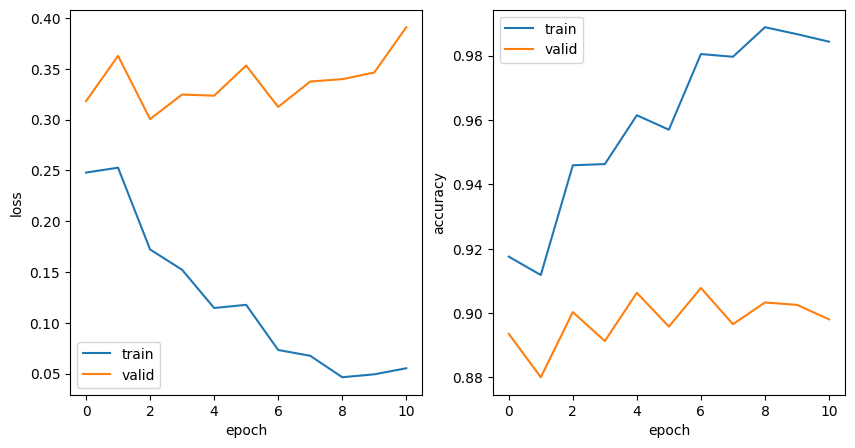

In [23]:
from matplotlib import pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].plot(np.array(log['train']).T[0], label="train")
ax[0].plot(np.array(log['valid']).T[0], label="valid")
ax[0].set_xlabel("epoch")
ax[0].set_ylabel("loss")
ax[0].legend()
ax[1].plot(np.array(log["train"]).T[1], label="train")
ax[1].plot(np.array(log["valid"]).T[1], label="valid")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("accuracy")
ax[1].legend()
plt.show()